In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read the data and count number of samples corresponding to each LCLid
power=pd.read_csv('Power-Networks-LCL.csv', index_col='LCLid')
a=power.groupby('LCLid').count()
a['Count']=a['KWh']
a=a.sort_values('KWh')
print(a['Count'].tail(3))

LCLid
MAC000021    39078
MAC000020    39078
MAC000018    39081
Name: Count, dtype: int64


In [4]:
#Get data of top 3 households.
data = pd.concat((power.loc['MAC000018'],power.loc['MAC000020'],power.loc['MAC000021']),axis=0)
data.index = pd.to_datetime(data['DateTime'])

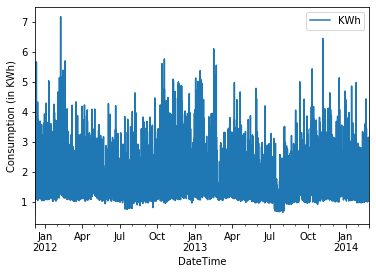

In [5]:
#Resampling of data on hourly basis
data = data.resample('H').sum()

data.plot()
plt.xlabel('DateTime')
plt.ylabel('Consumption (in KWh)')
plt.show()

In [6]:
#Split data in train and test with 75% training data and 25% testing data
train_len = int(len(data)*0.75)
train_set = data.head(train_len)

In [ ]:
#Scale data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_scaled= sc.fit_transform(train_set)

In [31]:
#Create input data with 22 timesteps and 1 output
X_train=[]
y_train=[]
for i in range(22,train_len):
    X_train.append(X_scaled[i-22:i, 0])
    y_train.append(X_scaled[i,0])

X_train, y_train= np.array(X_train),np.array(y_train)    

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1], 1))

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [33]:
model = Sequential()

In [34]:
model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

In [35]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

In [36]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

In [37]:
model.add(LSTM(units=50))
model.add(Dropout(0.2))

In [38]:
model.add(Dense(1))

In [39]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [40]:
#Training the final model
model.fit(X_train, y_train,epochs=50,batch_size=100)

Epoch 1/50
14624/14624 [==============================] - 13s 871us/step - loss: 0.0104
Epoch 2/50
14624/14624 [==============================] - 10s 672us/step - loss: 0.0091
Epoch 3/50
14624/14624 [==============================] - 11s 748us/step - loss: 0.0082
Epoch 4/50
14624/14624 [==============================] - 10s 711us/step - loss: 0.0066
Epoch 5/50
14624/14624 [==============================] - 11s 769us/step - loss: 0.0055
Epoch 6/50
14624/14624 [==============================] - 11s 772us/step - loss: 0.0051
Epoch 7/50
14624/14624 [==============================] - 11s 743us/step - loss: 0.0051
Epoch 8/50
14624/14624 [==============================] - 11s 760us/step - loss: 0.0048
Epoch 9/50
14624/14624 [==============================] - 11s 748us/step - loss: 0.0048
Epoch 10/50
14624/14624 [==============================] - 12s 790us/step - loss: 0.0048
Epoch 11/50
14624/14624 [==============================] - 12s 787us/step - loss: 0.0048
Epoch 12/50
14624/14624 [=====

In [41]:
#Save model to use in future
from keras.models import load_model
model.save("Forecast_consumption.h5")

In [42]:
#Prepare test data
test_len = len(data)-len(train_set)
x_test = data.tail(test_len)
test_data = data.tail(test_len+22)

In [43]:
data_total=pd.concat((train_set['KWh'],test_data['KWh']),axis=0)
inputs = data_total[len(data_total)-len(test_data)-22:].values
inputs = inputs.reshape(-1,1)
sc = MinMaxScaler(feature_range=(0,1))
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(22,test_len+22):
    X_test.append(inputs[i-22:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


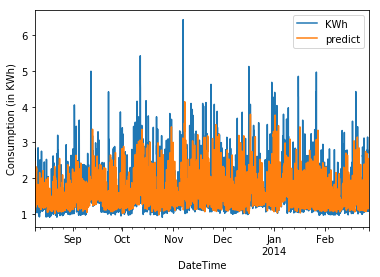

In [44]:
#Predict and plot data
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)
x_test['predict']=pred
x_test.plot()
plt.xlabel('DateTime')
plt.ylabel('Consumption (in KWh)')
plt.show()

In [45]:
#Forecast Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(x_test['KWh'],x_test['predict'])
print('MSE: '+'{:.2f}'.format(mse))

MSE: 0.37
